In [1]:
import pandas as pd                
from scipy.stats import iqr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Define IQR function
def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

In [3]:
# Function to calculate tidal statistics

def tidal_stats(data):
    try:
        # set root_url to github path with data
        root_url = 'https://github.com/MyreLab/thames-tidal-variation/raw/main/datasets/' 

        # Load datasets
        df = pd.read_csv(root_url+data) 

        # Take only the first three columns
        df = df.iloc[:, :3]

        # Rename columns
        df.columns = ['datetime', 'water_level', 'is_high_tide']

        # Convert to datetime
        df['datetime'] = pd.to_datetime(df['datetime'])

        # Convert to float
        df['water_level'] = df.water_level.astype(float)

        # Create extra month and year columns for easy access
        df['month'] = df['datetime'].dt.month
        df['year'] = df['datetime'].dt.year

        # Filter df for high and low tide
        tide_high = df.query('is_high_tide==1')['water_level']
        tide_low = df.query('is_high_tide==0')['water_level']

        # Create summary statistics
        high_statistics = tide_high.agg(['mean', 'median', IQR])
        low_statistics = tide_low.agg(['mean', 'median', IQR])

        # Calculate ratio of high tide days
        all_high_days = df.query('is_high_tide==1').groupby('year').count()['water_level']

        high_days = df.query(f'(water_level>{tide_high.quantile(.75)}) & (is_high_tide==1)').groupby('year').count()['water_level']

        high_ratio = (high_days/all_high_days).reset_index()

        # Calculate ratio of low tide days
        all_low_days = df.query('is_high_tide==0').groupby('year').count()['water_level']

        low_days = df.query(f'(water_level<{tide_low.quantile(.25)}) & (is_high_tide==0)').groupby('year').count()['water_level']

        low_ratio = (low_days/all_low_days).reset_index()

        solution = {
            'high_statistics': high_statistics,
            'low_statistics': low_statistics,
            'high_ratio': high_ratio,
            'low_ratio':low_ratio,
            'raw_data':df        
        }
        
    except:
        solution = 0

    return solution

In [4]:
# run tidal_stats function for all datasets along the Thames:

# Get filenames for all Thames data

filenames = [
    'London_Bridge.txt',
    'All_Hallows_Pier.txt',
    'Temple_Pier.txt',
    'Strand_on_Green.txt',
    'Richmond.txt',
    'Walton_on_Naze.txt',
    'Margate.txt',
    'Shivering_Sand.txt',
    'Southend.txt',
    'Coryton.txt',
    'Tilbury.txt',
    'Silvertown.txt',
    'Cherry_Garden_Pier.txt',  
]

# create list to store the resulting tidal statistics:

results_dict = {}

for dataset in filenames:
    results_dict[dataset.replace('.txt',"").replace('_'," ")] = tidal_stats(dataset)

In [183]:
results_dict['London Bridge']['high_statistics']

mean      3.318373
median    3.352600
IQR       0.743600
Name: water_level, dtype: float64

In [188]:
results_dict['London Bridge']['low_statistics']

mean     -2.383737
median   -2.412900
IQR       0.538200
Name: water_level, dtype: float64

In [133]:
# creating merged df for all raw data

# initializing an empty dataframe that will store merged data
thames_data = pd.DataFrame()

# for loop to populate the merged dataframe and add a 'Location' column for each tidal location
for key in list(results_dict.keys()):
    df = results_dict[key]['raw_data']
    df['Location'] = key
    thames_data = pd.concat([df, thames_data], sort=False)
        
thames_data

,datetime,water_level,is_high_tide,month,year,Location
0,1911-01-01 09:20:00,-2.7223,0,1,1911,Cherry Garden Pier
1,1911-01-01 15:15:00,3.5766,1,1,1911,Cherry Garden Pier
2,1911-02-01 09:50:00,-2.6207,0,2,1911,Cherry Garden Pier
3,1911-02-01 15:18:00,3.4750,1,2,1911,Cherry Garden Pier
4,1911-03-01 10:10:00,-2.5445,0,3,1911,Cherry Garden Pier
...,...,...,...,...,...,...
115498,1995-12-30 20:44:00,3.2900,1,12,1995,London Bridge
115499,1995-12-31 02:32:00,-1.6000,0,12,1995,London Bridge
115500,1995-12-31 08:59:00,3.2000,1,12,1995,London Bridge
115501,1995-12-31 15:03:00,-1.8000,0,12,1995,London Bridge


In [131]:
# sanity check to make sure all data has been merged into dataframe
x = 0
for key in list(results_dict.keys()):
    x += len(results_dict[key]['raw_data'])
x == len(thames_data)

True

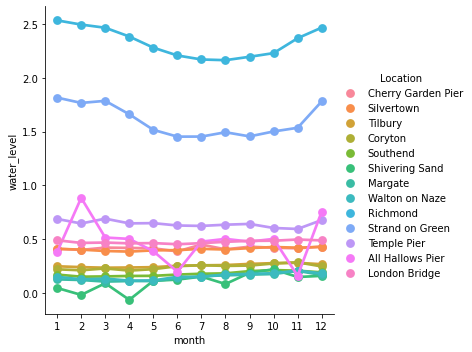

In [161]:
# plotting monthly average water level across all years for all gauge locations - comparing all in one chart

g = sns.catplot(
    x='month',
    y='water_level',
    data=thames_data,
    kind='point',
    hue='Location',
    ci=None
)

plt.show()

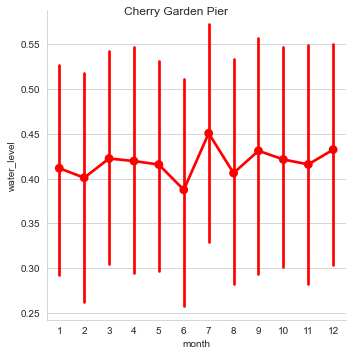

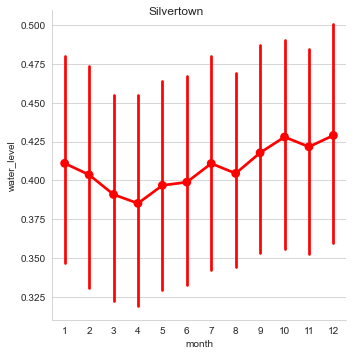

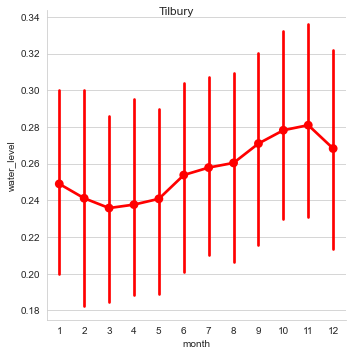

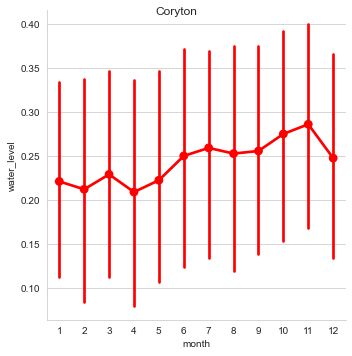

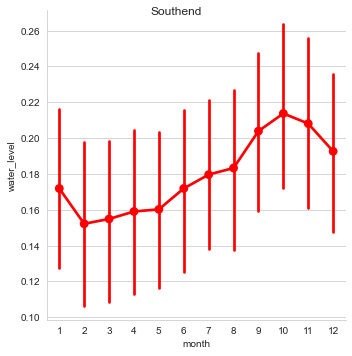

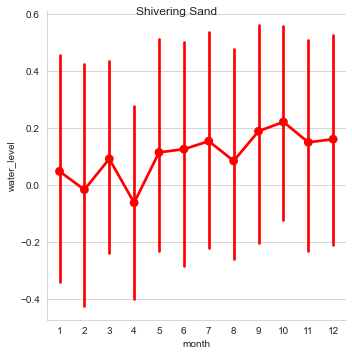

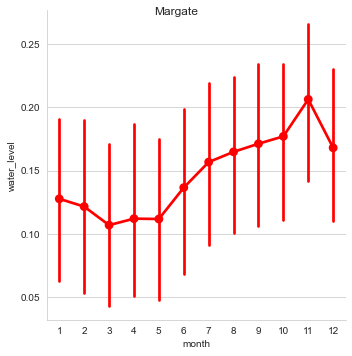

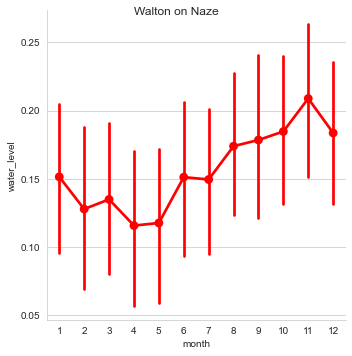

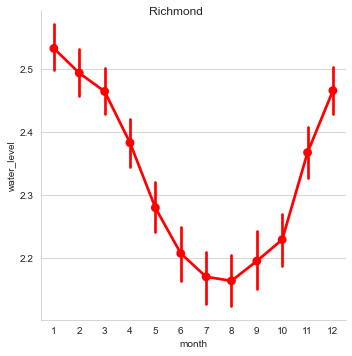

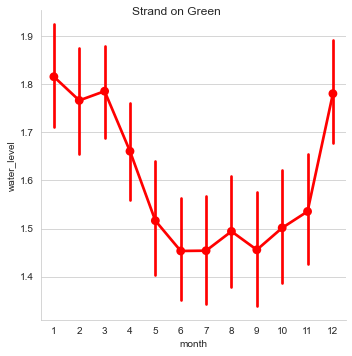

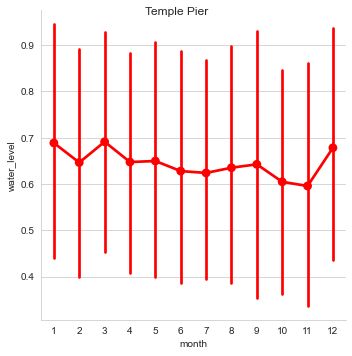

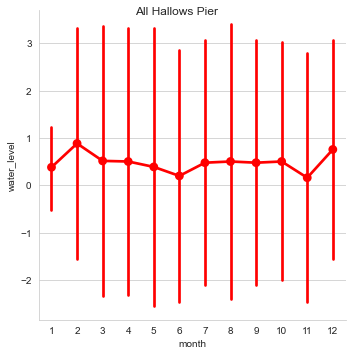

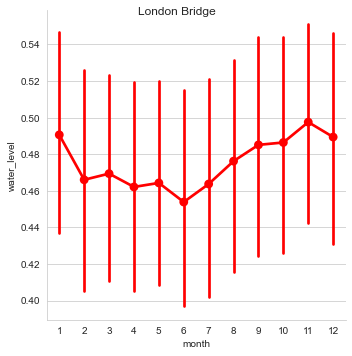

In [180]:
# plotting monthly average water level with confidence intervals across all years for each gauge location - comparing all in separate charts  location

sns.set_style("whitegrid")
for location in thames_data['Location'].unique():
    g = sns.catplot(
        x='month',
        y='water_level',
        data=thames_data[thames_data['Location'] == location],
        kind='point',
        color='red'
    )
    
    g.fig.suptitle(location)

    plt.show()

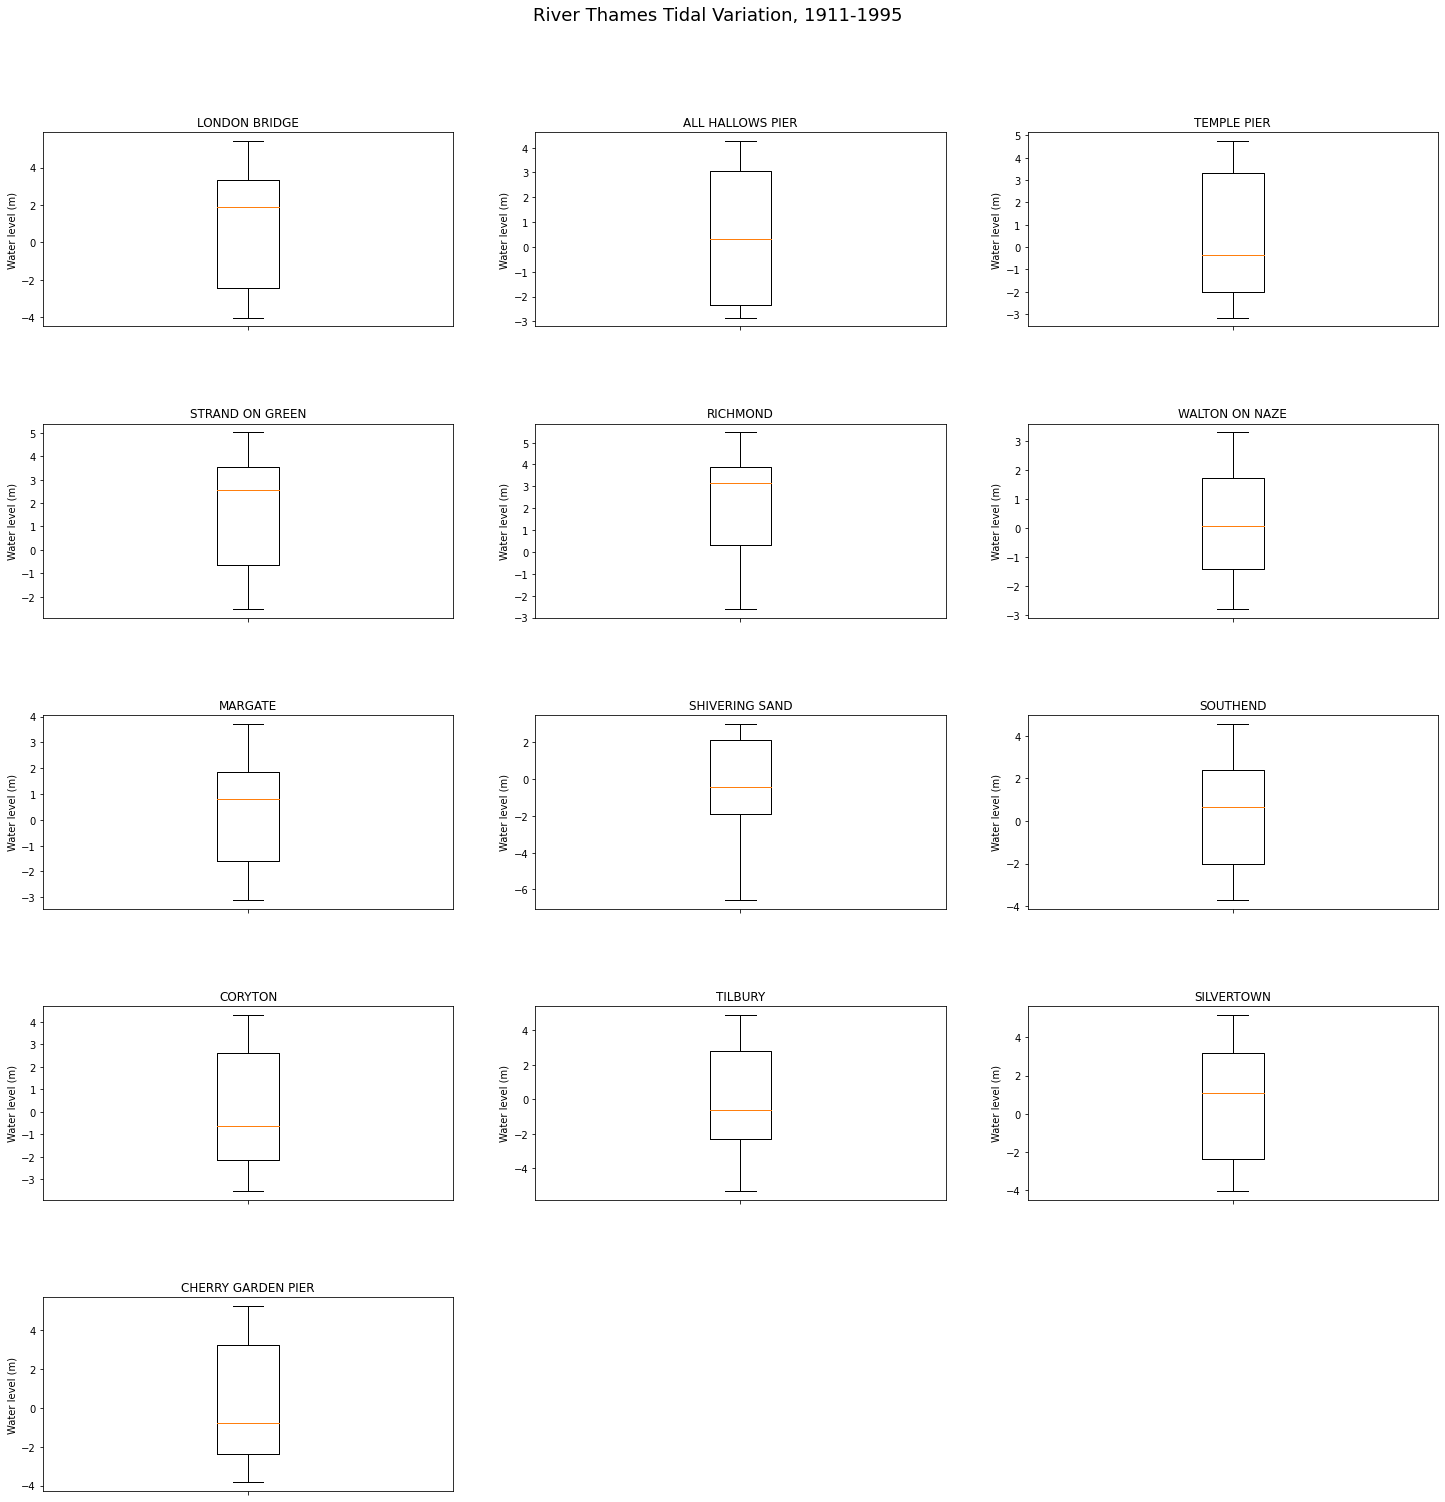

In [132]:
# plotting box plots for each gauge location to understand distribution of water levels 
# using results_dict

plt.figure(figsize=(25, 25))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("River Thames Tidal Variation, 1911-1995", fontsize=18, y=0.95)

# loop through the length of tickers and keep track of index

plot_list = []

for n, key in enumerate(list(results_dict.keys())):
    # add a new subplot iteratively
    
    ax = plt.subplot(5, 3, n + 1)

    # filter df and plot on the new subplot axis
    df_plot = results_dict[key]['raw_data']
    viz = ax.boxplot(df_plot['water_level'].dropna())

    # chart formatting
    ax.set_title(key.upper())
    ax.set_xlabel("")
    ax.set_xticklabels("")
    ax.set_ylabel("Water level (m)")
    
    plot_list.append(viz)